# Predizione di opportunità di Cross Sell di assicurazioni

Il cliente è una compagnia di assicurazioni che ha fornito un'assicurazione sanitaria ai suoi clienti, adesso hanno bisogno del tuo aiuto per costruire un modello predittivo in grado di prevedere se gli assicurati dell'anno passato potrebbero essere interessati ad acquistare anche un'assicurazione per il proprio veicolo.

Il dataset è composto dalle seguenti proprietà:
- **id**: id univoco dell'acquirente.
- **Gender**: sesso dell'acquirente.
- **Age**: età dell'acquirente.
- **Driving_License**: 1 se l'utente ha la patente di guida, 0 altrimenti.
- **Region_Code**: codice univoco della regione dell'acquirente.
- **Previously_Insured**: 
- **Vehicle_Age**: età del veicolo
- **Vehicle_Damage**: 1 se l'utente ha danneggiato il veicolo in passato, 0 altrimenti.
- **Annual_Premium**: la cifra che l'utente deve pagare come premio durante l'anno.
- **Policy_Sales_Channel**: codice anonimizzato del canale utilizzato per la proposta (es. per email, per telefono, di persona, ecc...)
- **Vintage**: numero di giorni dalla quale l'utente è cliente dell'azienda.
- **Response**: 1 se l'acquirente ha risposto positivametne alla proposta di vendità, 0 altrimenti.

L'obiettivo del modello è prevedere il valore di **Response** in base al valore delle altre proprietà

## Dipendenze

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from sklearn.feature_selection import mutual_info_classif
from tensorboard.plugins.hparams import api as hp
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
import seaborn as sns
from datetime import datetime

In [ ]:
pd.set_option('display.max_rows', 300)
plt.rcParams["figure.figsize"] = (60,15)
plt.rcParams['font.size'] = 14

## Scarichiamo il Dataset
Il dataset è disponibile su Kaggle a [questo indirizzo](https://www.kaggle.com/anmolkumar/health-insurance-cross-sell-prediction). Per scaricarlo usiamo direttamente le API di Kaggle. Creiamo il file json di autenticazione con il nostro nome utente Kaggle e la chiave.

In [ ]:
!mkdir ~/.kaggle/
!echo '{"username":"guizard","key":"9b4890694553490c6c688d77c3048922"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle/’: File exists


Ora scarichiamo il dataset

In [ ]:
!kaggle datasets download anmolkumar/health-insurance-cross-sell-prediction

health-insurance-cross-sell-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


ed estraiamo lo zip scaricato

In [ ]:
!unzip health-insurance-cross-sell-prediction.zip
!ls

Archive:  health-insurance-cross-sell-prediction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: health-insurance-cross-sell-prediction.zip  sample_submission.csv  train.csv
sample_data				    test.csv


## Carichiamo il Dataset
Per la creazione del nostro modello concentriamoci solo sul file train.csv. Carichiamolo dentro un dataframe di Pandas.

In [ ]:
df = pd.read_csv("train.csv")
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


## EDA Exploratory Data Analysis
Diamo un'occhio ai dati ! Iniziamo vedendo quanti esempi abbiamo a disposizione.

In [ ]:
df.count()

id                      381109
Gender                  381109
Age                     381109
Driving_License         381109
Region_Code             381109
Previously_Insured      381109
Vehicle_Age             381109
Vehicle_Damage          381109
Annual_Premium          381109
Policy_Sales_Channel    381109
Vintage                 381109
Response                381109
dtype: int64

Accipicchia un bel po' ! Ma saranno tutti dati validi ? Oppure ci saranno NaN e Null in mezzo ? Verifichiamolo.

In [ ]:
df.isna().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [ ]:
df.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

Nessun NaN e nessun Null, fantastico. Diamo uno sguardo al tipo delle diverse colonne.

In [ ]:
df.dtypes

id                        int64
Gender                   object
Age                       int64
Driving_License           int64
Region_Code             float64
Previously_Insured        int64
Vehicle_Age              object
Vehicle_Damage           object
Annual_Premium          float64
Policy_Sales_Channel    float64
Vintage                   int64
Response                  int64
dtype: object

In [ ]:
df["Region_Code"].unique().shape[0]

53

## Analisi delle variabili continue

In [ ]:
numerical_columns = ["Age","Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]

In [ ]:
df[numerical_columns].describe()

,Age,Region_Code,Annual_Premium,Policy_Sales_Channel,Vintage
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,26.388807,30564.389581,112.034295,154.347397
std,15.511611,13.229888,17213.155057,54.203995,83.671304
min,20.000000,0.000000,2630.000000,1.000000,10.000000
25%,25.000000,15.000000,24405.000000,29.000000,82.000000
50%,36.000000,28.000000,31669.000000,133.000000,154.000000
75%,49.000000,35.000000,39400.000000,152.000000,227.000000
max,85.000000,52.000000,540165.000000,163.000000,299.000000


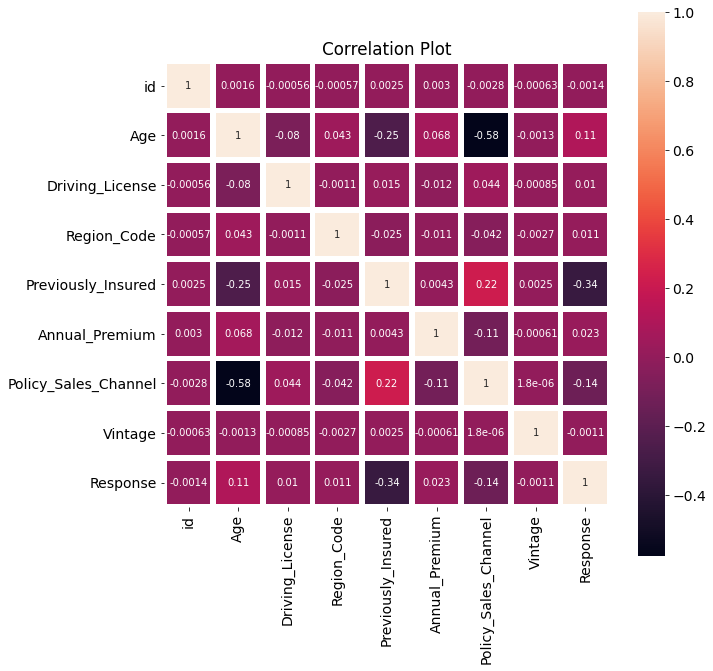

In [ ]:
plt.figure(figsize = (10,10))
plt.title("Correlation Plot")
sns.heatmap(df.corr(), linewidth = 5, annot = True, square = True, annot_kws={'size': 10})

## Analisi delle variabili qualitative

In [ ]:
categorical_columns = ["Gender","Driving_License", 'Previously_Insured', 'Vehicle_Age', 'Vehicle_Damage']

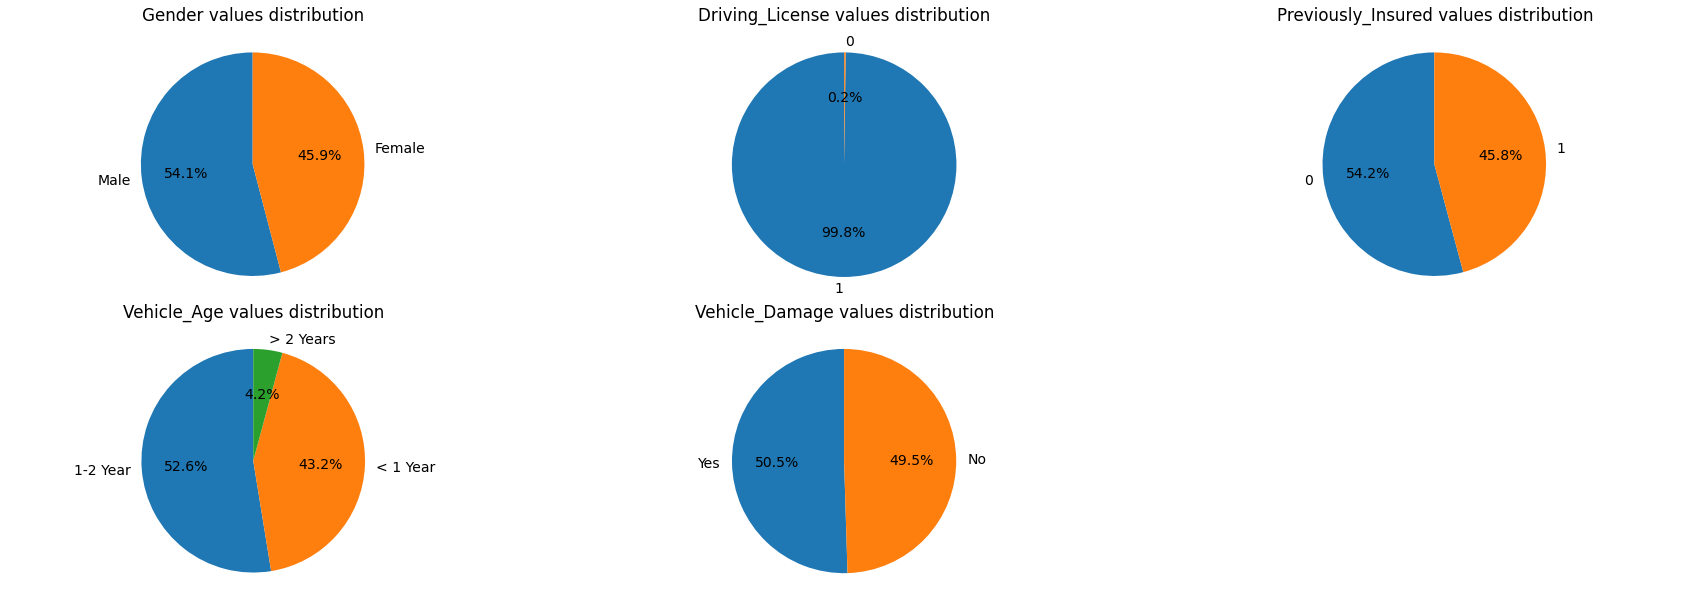

In [ ]:
plt.rcParams['font.size'] = 14

fig = plt.figure()
#fig.set_size_inches(30, 10)

ncols = 3
nrows = round(len(categorical_columns)/ncols)

for i, column in enumerate(categorical_columns):

  plot = fig.add_subplot(nrows, ncols, i+1)

  df_uniqdist = df[column].value_counts()

  plot.pie(df_uniqdist.values, 
          labels=df_uniqdist.index.values, 
          autopct='%1.1f%%',
          startangle=90)
  
  plot.title.set_text(column+" values distribution")
  plot.axis('equal')

  ttl = plot.title
  ttl.set_position([.5, 1.06])


plt.show()

In [ ]:
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


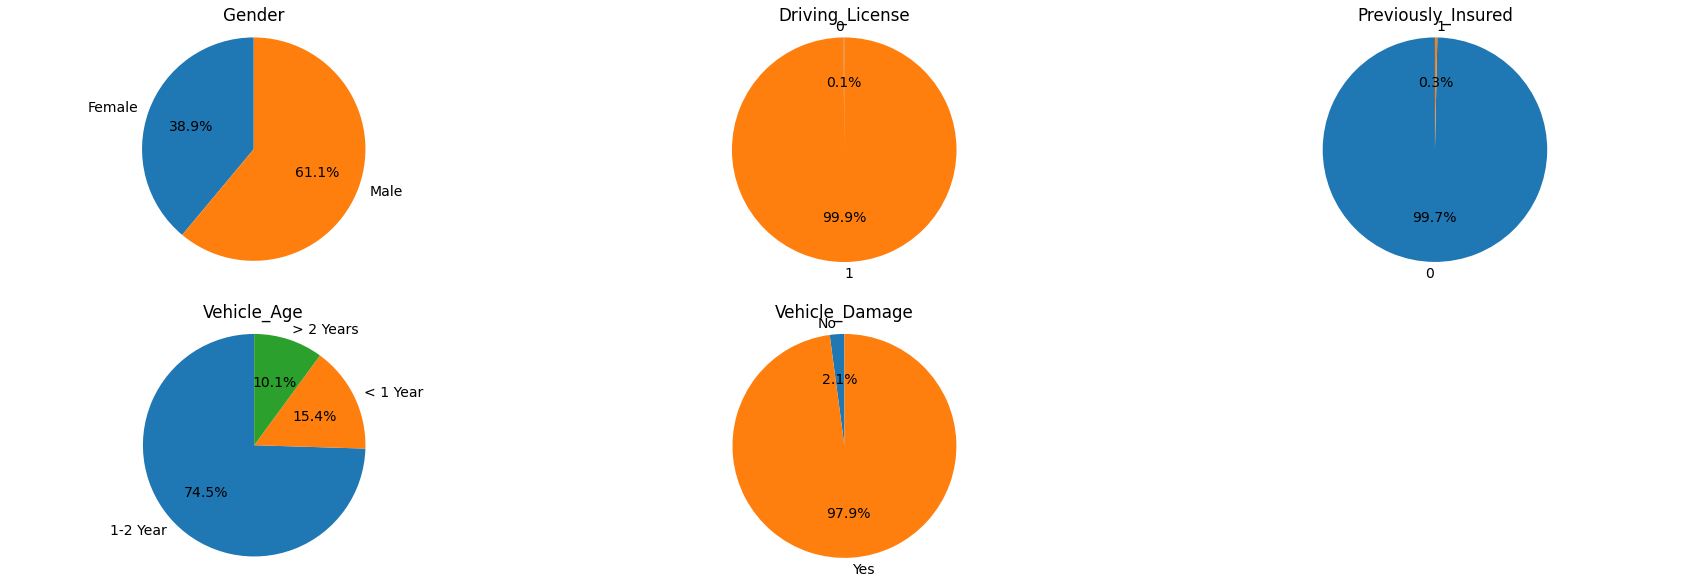

In [ ]:
fig = plt.figure()
#fig.set_size_inches(30, 10)

df_count = df.copy()
df_count["count"] = 1

for i, column in enumerate(categorical_columns):

  plot = fig.add_subplot(nrows, ncols, i+1)
  df_tmp = df_count.groupby([column,"Response"]).count()["count"].to_frame().reset_index()
  
  plot.pie(df_tmp[df_tmp["Response"]==1]["count"].values, 
        labels=df_tmp[column].unique(), 
        autopct='%1.1f%%',
        startangle=90)
  
  plot.title.set_text(column)
  plot.axis('equal')

plt.show()

## Approfondiamo Region Code e Policy Sales Channel

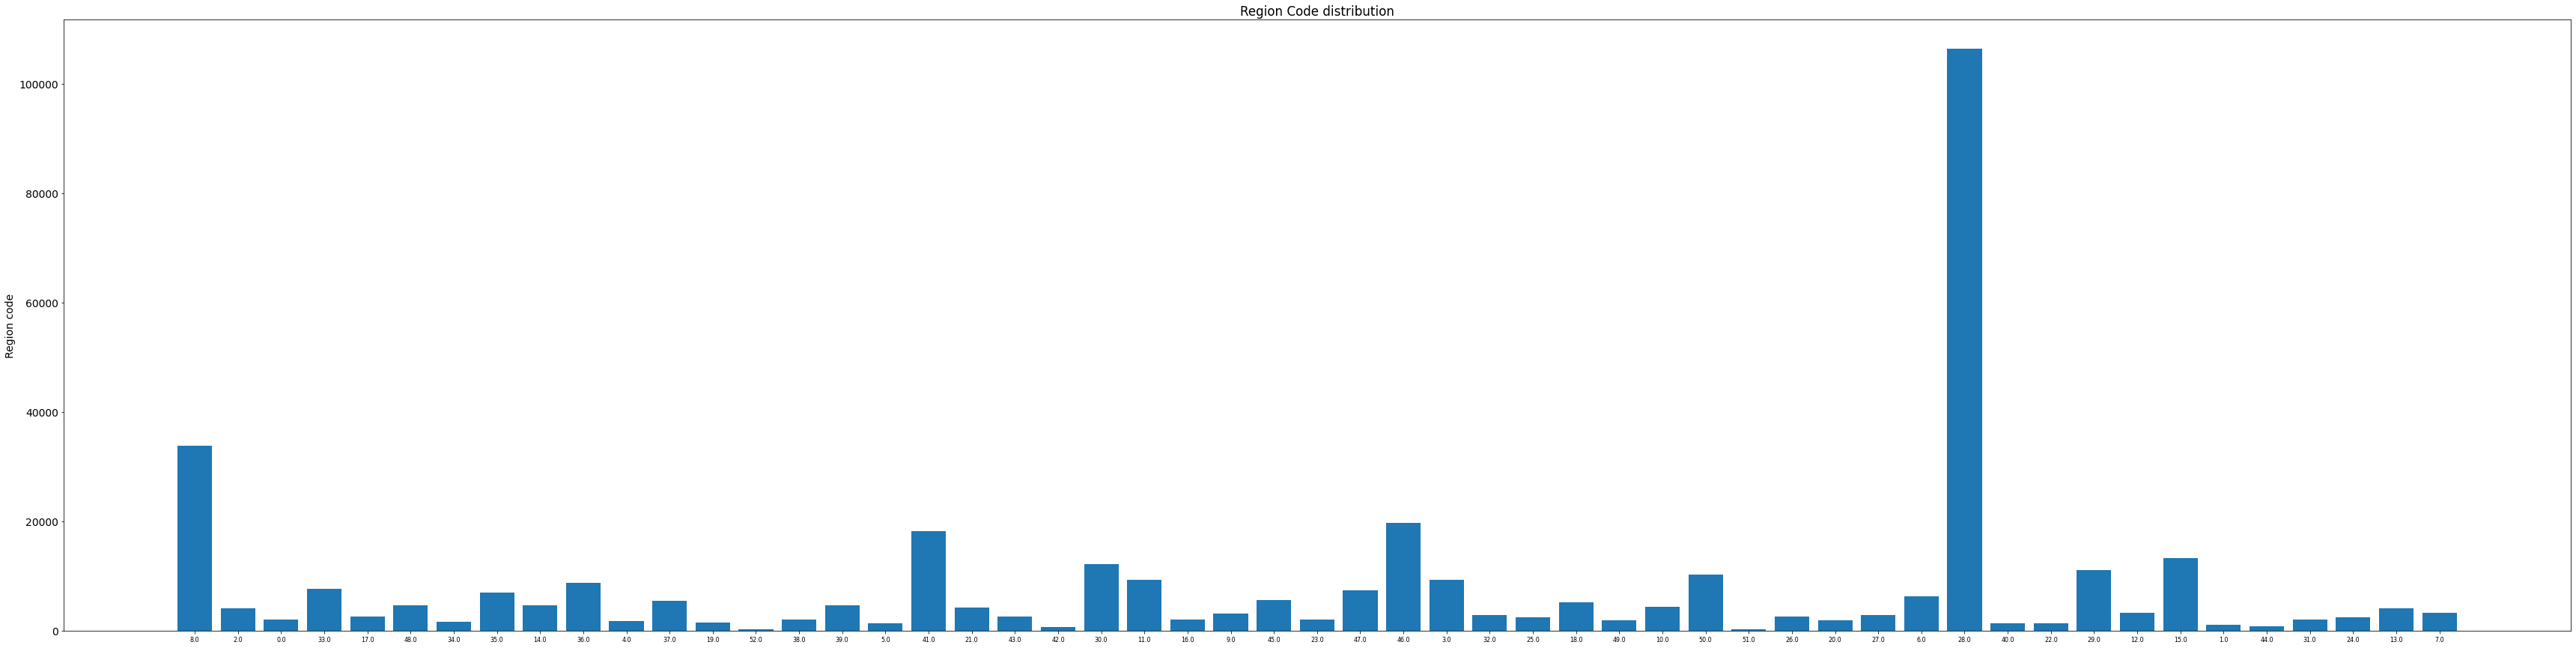

      Region_Code  Region_Code
28.0       106415     0.279225
8.0         33877     0.088891
46.0        19749     0.051820
41.0        18263     0.047921
15.0        13308     0.034919
30.0        12191     0.031988
29.0        11065     0.029034
50.0        10243     0.026877
3.0          9251     0.024274
11.0         9232     0.024224
36.0         8797     0.023083
33.0         7654     0.020083
47.0         7436     0.019511
35.0         6942     0.018215
6.0          6280     0.016478
45.0         5605     0.014707
37.0         5501     0.014434
18.0         5153     0.013521
48.0         4681     0.012283
14.0         4678     0.012275
39.0         4644     0.012185
10.0         4374     0.011477
21.0         4266     0.011194
2.0          4038     0.010595
13.0         4036     0.010590
7.0          3279     0.008604
12.0         3198     0.008391
9.0          3101     0.008137
27.0         2823     0.007407
32.0         2787     0.007313
43.0         2639     0.006925
17.0    

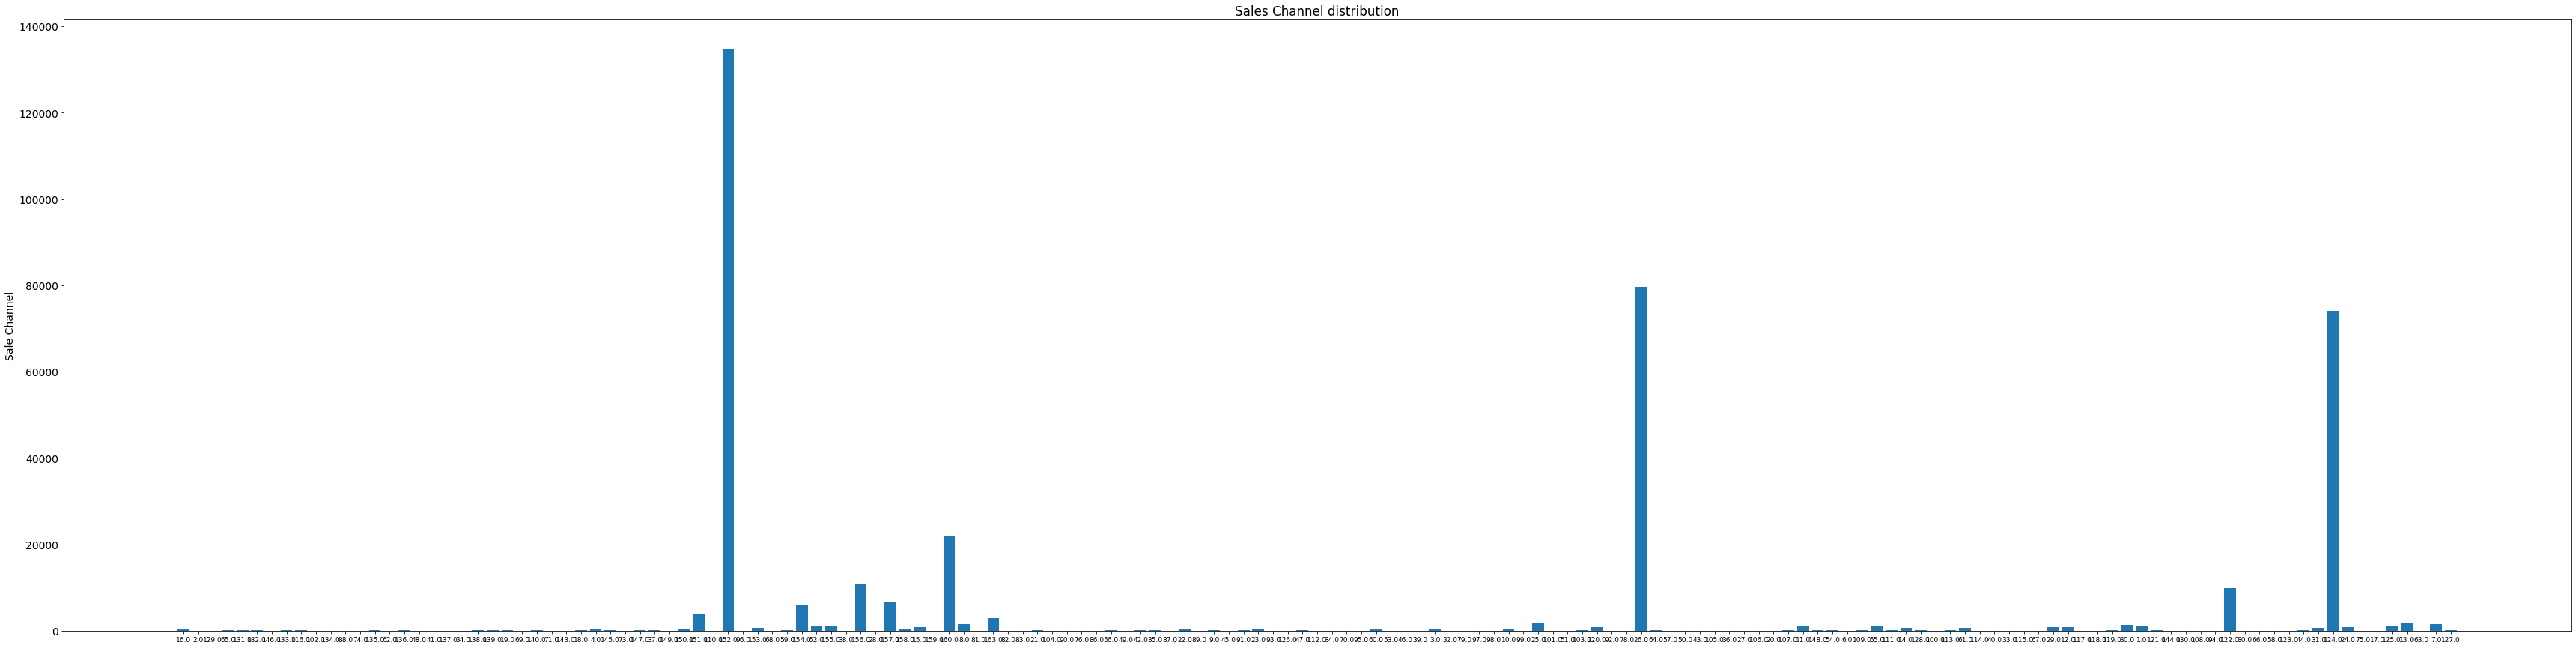

       Policy_Sales_Channel  Policy_Sales_Channel
152.0                134784              0.353663
26.0                  79700              0.209127
124.0                 73995              0.194157
160.0                 21779              0.057146
156.0                 10661              0.027974
122.0                  9930              0.026056
157.0                  6684              0.017538
154.0                  5993              0.015725
151.0                  3885              0.010194
163.0                  2893              0.007591
13.0                   1865              0.004894
25.0                   1848              0.004849
7.0                    1598              0.004193
8.0                    1515              0.003975
30.0                   1410              0.003700
55.0                   1264              0.003317
155.0                  1234              0.003238
11.0                   1203              0.003157
1.0                    1074              0.002818


In [ ]:
def plot_categorical_distribution(df, column, title=None, label=None, ticksize=12, print_first=None):

  serie_uniqdist = df[column].value_counts(sort=False)
  labels = serie_uniqdist.index.values
  y_pos = np.arange(len(labels))

  plt.bar(y_pos, serie_uniqdist.values)
  plt.xticks(y_pos, labels, fontsize=ticksize)
  plt.ylabel(label)
  plt.title(title)
  plt.show()

  if print_first:
    total = serie_uniqdist.sum()
    serie_uniqdist = serie_uniqdist.sort_values(ascending=False)
    serie_percentage = serie_uniqdist/total
    print(pd.concat([serie_uniqdist, serie_percentage], axis=1).head(print_first))


plot_categorical_distribution(df, "Region_Code", title="Region Code distribution", label="Region code", ticksize=8, print_first=300)
plot_categorical_distribution(df, "Policy_Sales_Channel", title="Sales Channel distribution", label="Sale Channel", ticksize=9, print_first=300)

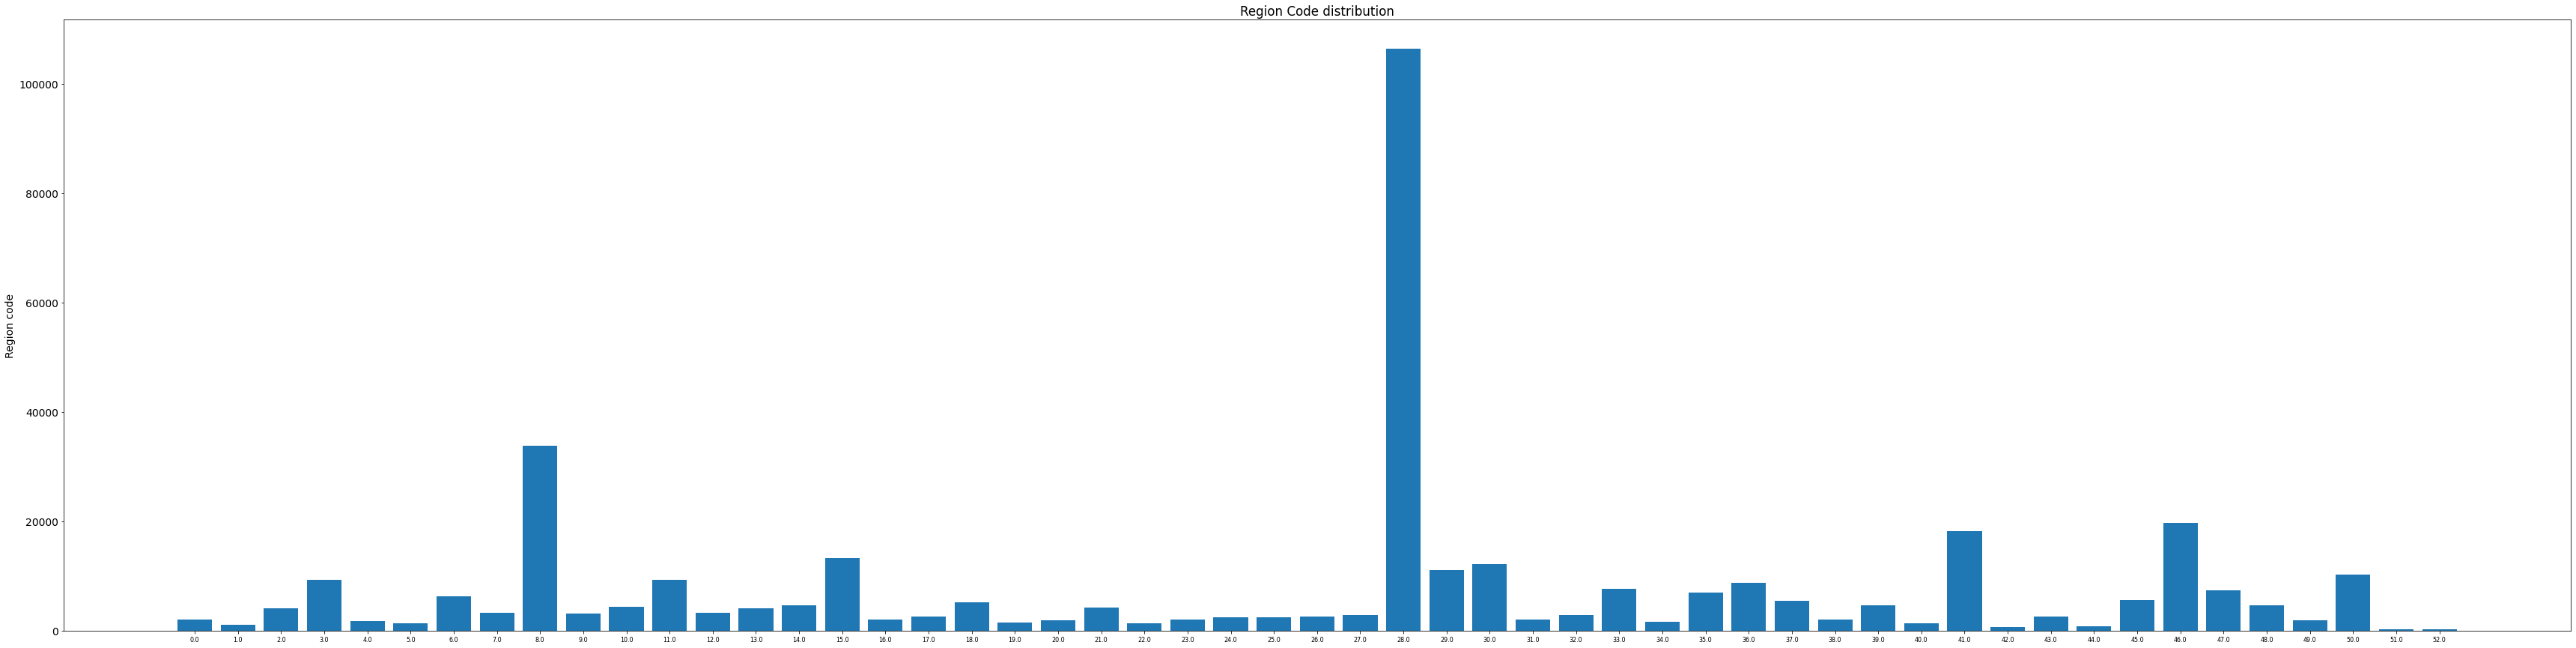

             Response  Percentage
Region_Code                      
28.0           106415    0.187163
8.0             33877    0.096142
46.0            19749    0.102891
41.0            18263    0.121776
15.0            13308    0.071987
30.0            12191    0.073825
29.0            11065    0.123362
50.0            10243    0.062677
3.0              9251    0.127662
11.0             9232    0.112760
36.0             8797    0.079914
33.0             7654    0.099294
47.0             7436    0.087682
35.0             6942    0.124604
6.0              6280    0.069904
45.0             5605    0.109723
37.0             5501    0.079258
18.0             5153    0.131574
48.0             4681    0.101901
14.0             4678    0.090209
39.0             4644    0.123600
10.0             4374    0.060128
21.0             4266    0.071027
2.0              4038    0.071075
13.0             4036    0.090188
7.0              3279    0.131747
12.0             3198    0.097561
9.0           

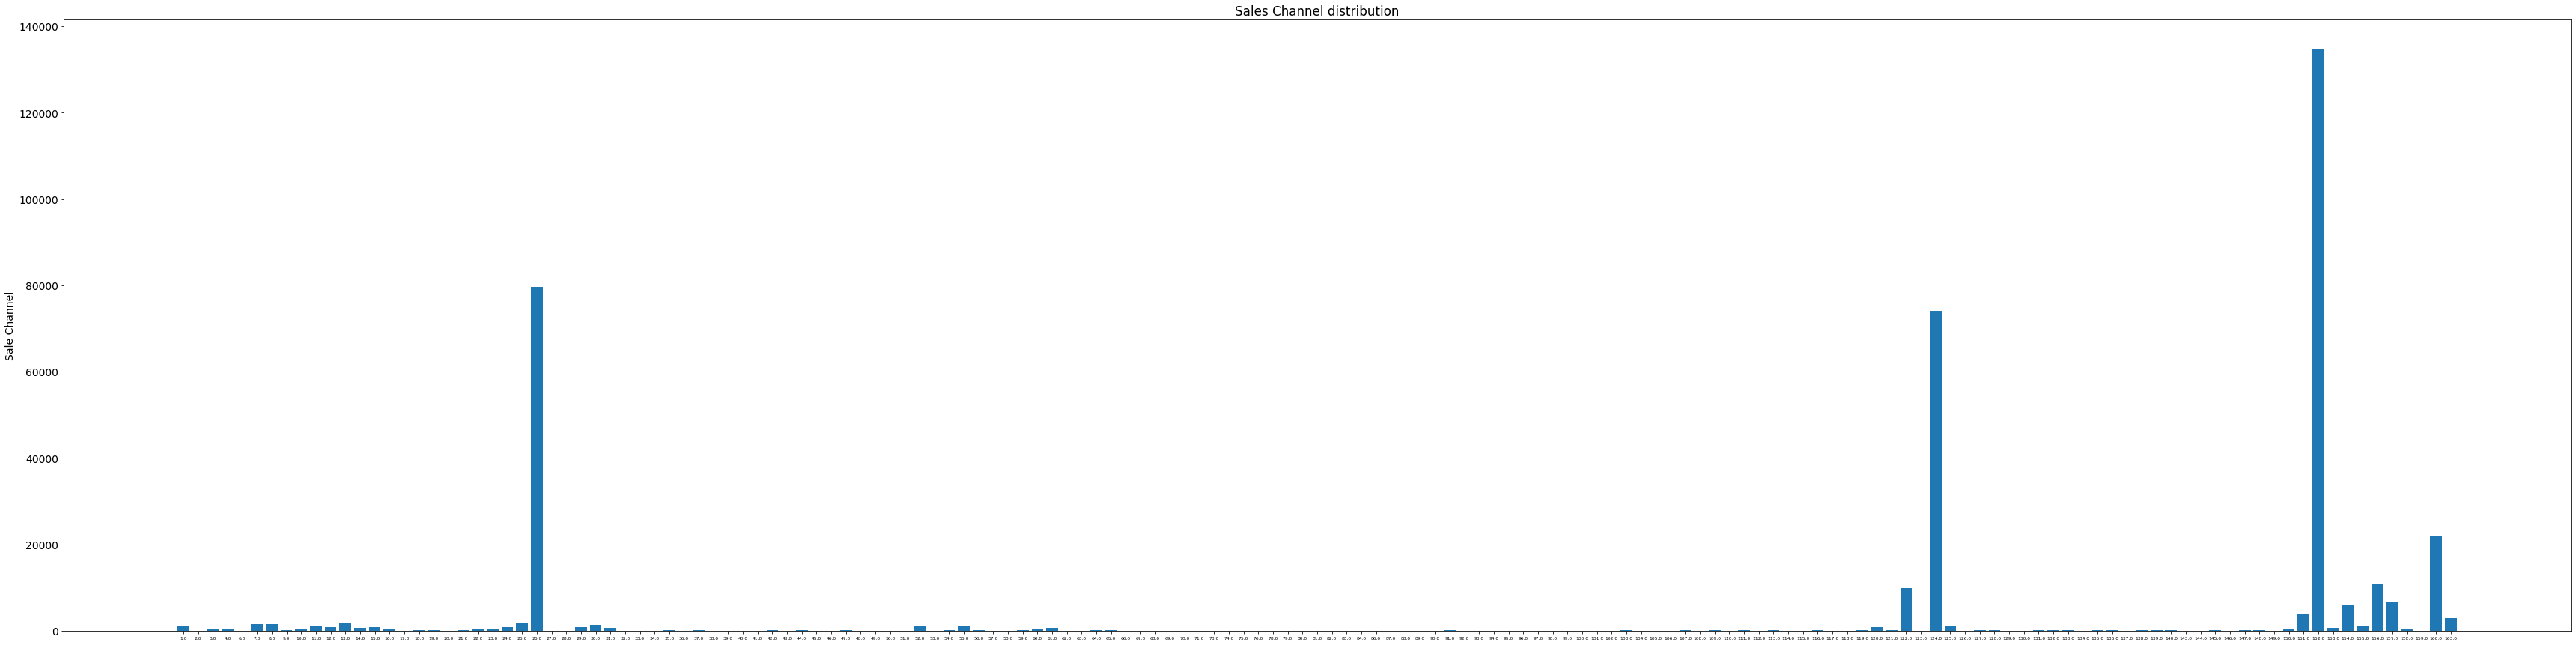

                      Response  Percentage
Policy_Sales_Channel                      
152.0                   134784    0.028624
26.0                     79700    0.199385
124.0                    73995    0.189148
160.0                    21779    0.021810
156.0                    10661    0.215458
122.0                     9930    0.173212
157.0                     6684    0.268402
154.0                     5993    0.245954
151.0                     3885    0.031403
163.0                     2893    0.304183
13.0                      1865    0.147453
25.0                      1848    0.199675
7.0                       1598    0.113892
8.0                       1515    0.082508
30.0                      1410    0.110638
55.0                      1264    0.149525
155.0                     1234    0.320097
11.0                      1203    0.089776
1.0                       1074    0.032588
52.0                      1055    0.109005
125.0                     1026    0.123782
15.0       

In [ ]:
def plot_categorical_correlation(df, column, target, title=None, label=None, ticksize=12, print_first=None):

  df_tmp = df[[column, target]].copy()

  df_tmp = df_tmp.groupby([column])
  df_sum = df_tmp.sum()
  df_count = df_tmp.count()

  df_count["Percentage"] = df_sum["Response"]/df_count["Response"]

  values = df_count["Response"].values
  labels = df_count.index.values
  y_pos = np.arange(len(labels))

  plt.bar(y_pos, values)
  plt.xticks(y_pos, labels, fontsize=ticksize)
  plt.ylabel(label)
  plt.title(title)
  plt.show()

  if print_first:
    print(df_count.sort_values("Response", ascending=False).head(print_first))

  
plot_categorical_correlation(df, "Region_Code", "Response", title="Region Code distribution", label="Region code", ticksize=8, print_first=200)
plot_categorical_correlation(df, "Policy_Sales_Channel", "Response", title="Sales Channel distribution", label="Sale Channel", ticksize=6, print_first=200)

## Analisi del target

In [ ]:
fig, axis = plt.subplots(1, 2, figsize = (14, 5))

df_uniqdist = df["Response"].value_counts()
y_pos = np.arange(len(df_uniqdist.index.values))

axis[0].bar(y_pos, df_uniqdist.values, align='center', alpha=0.5)
axis[0].set_xticks(y_pos)
axis[0].set_xticklabels(("Rejected (0)","Accepted (1)"))
axis[0].set_ylabel('Count')
axis[0].set_title('Clients response Count')

axis[1].pie(df_uniqdist.values, 
          labels=df_uniqdist.index.values, 
          autopct='%1.1f%%',
          startangle=90)

axis[1].set_title('Clients response Distribution')

plt.show()

## Feature Engineering

In [ ]:
mic = mutual_info_classif(df[numerical_columns], df["Response"])
df_mic = pd.DataFrame({'column':numerical_columns, 'correlation':mic})
df_mic = df_mic.sort_values(by=['correlation'], ascending=False)
df_mic.head()

,column,correlation
3,Policy_Sales_Channel,0.059095
0,Age,0.030700
1,Region_Code,0.014832
2,Annual_Premium,0.003687
4,Vintage,0.000741


In [ ]:
df = df.drop(["id","Vintage"], axis=1)

In [ ]:
df["Gender"] = df["Gender"].map({'Male':1, 'Female':0})
df["Vehicle_Damage"] = df["Vehicle_Damage"].map({'Yes':1, 'No':0})
df["Vehicle_Age"] = df["Vehicle_Age"].map({'> 2 Years':2, '1-2 Year':1.5, '< 1 Year':1 })
df.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Response
0,1,44,1,28.0,0,2.0,1,40454.0,26.0,1
1,1,76,1,3.0,0,1.5,0,33536.0,26.0,0
2,1,47,1,28.0,0,2.0,1,38294.0,26.0,1
3,1,21,1,11.0,1,1.0,0,28619.0,152.0,0
4,0,29,1,41.0,1,1.0,0,27496.0,152.0,0


In [ ]:
def group_channels(channel):
  positive_channels = [38., 124., 152., 156., 157., 122.]
  return channel if channel in positive_channels else 0

df["Policy_Sales_Channel"] = df["Policy_Sales_Channel"].apply(group_channels)
df.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,0.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,0.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,0.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [ ]:
df = pd.get_dummies(df, columns=["Policy_Sales_Channel", "Region_Code"])
df.head()

,Gender,Age,Driving_License,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Response,Policy_Sales_Channel_1.0,Policy_Sales_Channel_2.0,Policy_Sales_Channel_3.0,Policy_Sales_Channel_4.0,Policy_Sales_Channel_6.0,Policy_Sales_Channel_7.0,Policy_Sales_Channel_8.0,Policy_Sales_Channel_9.0,Policy_Sales_Channel_10.0,Policy_Sales_Channel_11.0,Policy_Sales_Channel_12.0,Policy_Sales_Channel_13.0,Policy_Sales_Channel_14.0,Policy_Sales_Channel_15.0,Policy_Sales_Channel_16.0,Policy_Sales_Channel_17.0,Policy_Sales_Channel_18.0,Policy_Sales_Channel_19.0,Policy_Sales_Channel_20.0,Policy_Sales_Channel_21.0,Policy_Sales_Channel_22.0,Policy_Sales_Channel_23.0,Policy_Sales_Channel_24.0,Policy_Sales_Channel_25.0,Policy_Sales_Channel_26.0,Policy_Sales_Channel_27.0,Policy_Sales_Channel_28.0,Policy_Sales_Channel_29.0,Policy_Sales_Channel_30.0,Policy_Sales_Channel_31.0,Policy_Sales_Channel_32.0,Policy_Sales_Channel_33.0,...,Region_Code_13.0,Region_Code_14.0,Region_Code_15.0,Region_Code_16.0,Region_Code_17.0,Region_Code_18.0,Region_Code_19.0,Region_Code_20.0,Region_Code_21.0,Region_Code_22.0,Region_Code_23.0,Region_Code_24.0,Region_Code_25.0,Region_Code_26.0,Region_Code_27.0,Region_Code_28.0,Region_Code_29.0,Region_Code_30.0,Region_Code_31.0,Region_Code_32.0,Region_Code_33.0,Region_Code_34.0,Region_Code_35.0,Region_Code_36.0,Region_Code_37.0,Region_Code_38.0,Region_Code_39.0,Region_Code_40.0,Region_Code_41.0,Region_Code_42.0,Region_Code_43.0,Region_Code_44.0,Region_Code_45.0,Region_Code_46.0,Region_Code_47.0,Region_Code_48.0,Region_Code_49.0,Region_Code_50.0,Region_Code_51.0,Region_Code_52.0
0,1,44,1,0,2.0,1,40454.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,76,1,0,1.5,0,33536.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1,47,1,0,2.0,1,38294.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,21,1,1,1.0,0,28619.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,29,1,1,1.0,0,27496.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
def group_age(age):
  if age<=30:
    return "20-30"
  if age<=40:
    return "30-40"
  if age<=50:
    return "40-50"
  if age<=60:
    return "50-60"
  return "60+"

#df["Age"] = df["Age"].apply(group_age)
#df.head()

In [ ]:
# df = pd.get_dummies(df, columns=["Vehicle_Age", "Age"])
# df.head()

In [ ]:
X = df.drop(["Response"], axis=1).values
y = df[["Response"]].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

## Neural Network

In [ ]:
def build_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
  return model

In [ ]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=256, validation_split=0.1)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
def plot_confusion_matrix(model, labels=["Negative", "Positive"], threeshold=0.5):
  y_proba = model.predict(X_test)
  y_pred = np.where(y_proba>threeshold,1,0)
  cm = confusion_matrix(y_pred, y_test)
  df_cm = pd.DataFrame(cm, index = ["Predicted "+labels[0],"Predicted "+labels[1]],
                    columns = labels)
  sns.heatmap(df_cm, annot=True, fmt='g')

plot_confusion_matrix(model, ["Rejected", "Accepted"])

In [ ]:
%tensorboard --logdir logs/fit

## Tecnica 1: Class Weighting

In [ ]:
total = y.shape[0]
pos = y[y==1].shape[0]
pos_weight = (1 / pos)*(total)/2.0
class_weight = {0: 1, 1: pos_weight}

In [ ]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, class_weight=class_weight, batch_size=128, validation_split=0.1)

NameError: ignored

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plot_confusion_matrix(model, ["Rejected", "Accepted"])

## Tecnica 2: Undersampling

In [ ]:
def split_data_by_label(df, target_column):
  
  y = df[target_column].values
  bool_labels = y!=0

  pos_features = df[bool_labels]
  neg_features = df[~bool_labels]

  pos_features = pos_features.drop(target_column, axis=1).values
  neg_features = neg_features.drop(target_column, axis=1).values

  pos_labels = y[bool_labels]
  neg_labels = y[~bool_labels]

  return pos_features, neg_features, pos_labels, neg_labels

In [ ]:
def concatenate(pos_features, neg_features, pos_labels, neg_labels):
  
  concat_features = np.concatenate([neg_features, pos_features], axis=0)
  concat_labels = np.concatenate([neg_labels, pos_labels], axis=0)

  order = np.arange(len(concat_labels))
  np.random.shuffle(order)
  concat_features = concat_features[order]
  concat_labels = concat_labels[order]

  return concat_features, concat_labels

In [ ]:
def undersample(df, target_column):
  
  pos_features, neg_features, pos_labels, neg_labels = split_data_by_label(df, target_column)
  
  ids = np.arange(len(neg_features))
  choices = np.random.choice(ids, len(pos_features))

  res_neg_features = neg_features[choices]
  res_neg_labels = neg_labels[choices]

  res_features, res_labels = concatenate(pos_features, res_neg_features, pos_labels, res_neg_labels)
  return res_features, res_labels

In [ ]:
X_undersampled, y_undersampled = undersample(df, "Response")
print("Number of samples: "+str(X_undersampled.shape))
print("Labels distribution: "+str(np.unique(y_undersampled,return_counts=True)))

Number of samples: (93420, 215)
Labels distribution: (array([0, 1]), array([46710, 46710]))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2)

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=20, batch_size=512, validation_split=0.1)

Epoch 1/20
132/132 [==============================] - 1s 5ms/step - loss: 0.5708 - accuracy: 0.7139 - val_loss: 0.4355 - val_accuracy: 0.7926
Epoch 2/20
132/132 [==============================] - 0s 4ms/step - loss: 0.4324 - accuracy: 0.7948 - val_loss: 0.4309 - val_accuracy: 0.7966
Epoch 3/20
132/132 [==============================] - 0s 4ms/step - loss: 0.4284 - accuracy: 0.7967 - val_loss: 0.4303 - val_accuracy: 0.7956
Epoch 4/20
132/132 [==============================] - 0s 3ms/step - loss: 0.4231 - accuracy: 0.7992 - val_loss: 0.4300 - val_accuracy: 0.7949
Epoch 5/20
132/132 [==============================] - 0s 3ms/step - loss: 0.4170 - accuracy: 0.8037 - val_loss: 0.4312 - val_accuracy: 0.7944
Epoch 6/20
132/132 [==============================] - 0s 3ms/step - loss: 0.4171 - accuracy: 0.8035 - val_loss: 0.4306 - val_accuracy: 0.7944
Epoch 7/20
132/132 [==============================] - 0s 3ms/step - loss: 0.4183 - accuracy: 0.8008 - val_loss: 0.4324 - val_accuracy: 0.7930
Epoch 

In [ ]:
model.evaluate(X_test, y_test)

584/584 [==============================] - 1s 2ms/step - loss: 0.4353 - accuracy: 0.8007


[0.4353078305721283, 0.8006851077079773]

In [ ]:
plot_confusion_matrix(model, ["Rejected", "Accepted"])

NameError: ignored

## Tecnica 3: Oversampling

In [ ]:
def oversample(df, target_column):
  
  pos_features, neg_features, pos_labels, neg_labels = split_data_by_label(df, target_column)
  
  ids = np.arange(len(pos_features))
  choices = np.random.choice(ids, len(neg_features))

  res_pos_features = pos_features[choices]
  res_pos_labels = pos_labels[choices]

  res_features, res_labels = concatenate(res_pos_features, neg_features, res_pos_labels, neg_labels)
  return res_features, res_labels

X_oversampled, y_oversampled = oversample(df, "Response")
print("Number of samples: "+str(X_oversampled.shape))
print("Labels distribution: "+str(np.unique(y_oversampled,return_counts=True)))

Number of samples: (668798, 215)
Labels distribution: (array([0, 1]), array([334399, 334399]))


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.2)

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)

Epoch 1/50
1881/1881 [==============================] - 6s 3ms/step - loss: 0.4491 - accuracy: 0.7848 - val_loss: 0.4182 - val_accuracy: 0.8003
Epoch 2/50
1881/1881 [==============================] - 6s 3ms/step - loss: 0.4225 - accuracy: 0.7987 - val_loss: 0.4161 - val_accuracy: 0.8024
Epoch 3/50
1881/1881 [==============================] - 6s 3ms/step - loss: 0.4166 - accuracy: 0.8026 - val_loss: 0.4147 - val_accuracy: 0.8032
Epoch 4/50
1881/1881 [==============================] - 6s 3ms/step - loss: 0.4151 - accuracy: 0.8022 - val_loss: 0.4127 - val_accuracy: 0.8038
Epoch 5/50
1881/1881 [==============================] - 6s 3ms/step - loss: 0.4123 - accuracy: 0.8034 - val_loss: 0.4098 - val_accuracy: 0.8043
Epoch 6/50
1881/1881 [==============================] - 6s 3ms/step - loss: 0.4096 - accuracy: 0.8057 - val_loss: 0.4079 - val_accuracy: 0.8060
Epoch 7/50
1881/1881 [==============================] - 6s 3ms/step - loss: 0.4084 - accuracy: 0.8055 - val_loss: 0.4078 - val_accuracy:

In [ ]:
model.evaluate(X_test, y_test)

4180/4180 [==============================] - 7s 2ms/step - loss: 0.3841 - accuracy: 0.8258


[0.3840586543083191, 0.8257550597190857]

In [ ]:
plot_confusion_matrix(model, ["Rejected", "Accepted"])1

SyntaxError: ignored

## Tensorboard

In [ ]:
%load_ext tensorboard
!rm -rf ./logs/

In [ ]:
class TestCallback(Callback):

    def __init__(self, X_test, y_test, log_dir):
        self.X_test = X_test
        self.tesy_testt_data = y_test
        self.log_dir = log_dir
        

    def on_train_end(self, logs=None):
      loss, accuracy = self.model.evaluate(X_test, y_test)      
      
      with tf.summary.create_file_writer(self.log_dir+"/test").as_default():
        tf.summary.scalar('test_loss', data=loss, step=1)
        tf.summary.scalar('test_accuracy', data=accuracy, step=1)
     
      print("Test Loss: %.4f, Test Accuracy: %.4f" % (loss, accuracy))
      return loss, accuracy

In [ ]:
log_dir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")

print(logdir)

model = build_model()
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model.fit(X_train, y_train, epochs=10, batch_size=128, validation_split=0.1, callbacks=[tensorboard_callback, TestCallback(X_test, y_test, log_dir)])

In [ ]:
%tensorboard --logdir logs/scalars

In [ ]:
!tensorboard dev upload \
  --logdir logs/fit \
  --name "Health Insurance Cross Sell Prediction" \
  --description "Predict Health Insurance Owners' who will be interested in Vehicle Insurance" \
  --one_shot

## Tuning degli Iperparametri

In [ ]:
!rm -rf ./logs/

In [ ]:
HP_NUM_UNITS = hp.HParam('num_units', hp.Discrete([16, 8]))
HP_OPTIMIZER = hp.HParam('optimizer', hp.Discrete(['adam', 'sgd']))
METRIC_ACCURACY = 'accuracy'

In [ ]:
def tune_model(hparams):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], input_dim=X_train.shape[1], activation='relu'))
  model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
  model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
  model.add(tf.keras.layers.Dense(hparams[HP_NUM_UNITS], activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
  model.compile(loss='binary_crossentropy', optimizer=hparams[HP_OPTIMIZER], metrics=['accuracy'])
  return model

In [ ]:
def run(log_dir, hparams):

    hp.hparams(hparams) 
    model = tune_model(hparams)
    
    model.fit(X_train, y_train, 
              epochs=10, batch_size=512,
              validation_split = 0.1,
              callbacks=[
                  tf.keras.callbacks.TensorBoard(log_dir),
                  hp.KerasCallback(log_dir, hparams),
                  TestCallback(X_test, y_test, log_dir)
              ],
    )

In [ ]:
session_num = 0

for num_units in HP_NUM_UNITS.domain.values:
  for optimizer in HP_OPTIMIZER.domain.values:
      hparams = {
          HP_NUM_UNITS: num_units,
          HP_OPTIMIZER: optimizer,
      }
      run_name = "run-%d" % session_num
      print('--- Starting trial: %s' % run_name)
      print({h.name: hparams[h] for h in hparams})
      run('logs/hparam_tuning/' + run_name, hparams)
      session_num += 1

In [ ]:
%tensorboard --logdir logs/hparam_tuning

In [ ]:
!tensorboard dev upload \
  --logdir logs/fit \
  --name "Health Insurance Cross Sell Prediction" \
  --description "Predict Health Insurance Owners' who will be interested in Vehicle Insurance" \
  --one_shot

## Esportare il modello

In [ ]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [ ]:
model.save("model/model.h5")

In [ ]:
from joblib import dump
dump(ss, 'model/standard_scaler.joblib')

['model/standard_scaler.joblib']

Proviamo ad importare

In [ ]:
model = load_model("model/model.h5")

In [ ]:
from joblib import load
ss = load('model/standard_scaler.joblib')

In [ ]:
# ss = ss.transform(X_test, y_test)
model.evaluate(X_test, y_test)

4180/4180 [==============================] - 6s 1ms/step - loss: 0.3841 - accuracy: 0.8258


[0.3840586543083191, 0.8257550597190857]

## Esportare il modello in modo migliore

In [ ]:
X_resampled, y_resampled = undersample(df, "Response")
# X_resampled, y_resampled = oversample(df, "Response")
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2)

mean = X_train.mean(axis=0)
sd = X_train.std(axis=0)

In [ ]:
(X_train[0] - mean)/(sd+0.00001)

array([-1.15732177e+00, -1.95600940e-01,  3.82077505e-02, -5.97861186e-01,
        4.32437198e-01,  6.40303628e-01, -1.60984878e+00, -4.57252368e-02,
       -5.16317871e-03, -4.71715047e-02, -4.30006284e-02,  0.00000000e+00,
       -6.44237954e-02, -5.87320909e-02, -2.16356590e-02, -2.99448502e-02,
       -5.26914194e-02, -4.71715047e-02, -7.19492542e-02, -3.80317810e-02,
       -4.61638330e-02, -3.45193745e-02, -7.30606359e-03, -1.75355059e-02,
       -2.22458128e-02, -9.66842872e-03, -1.50737408e-02, -2.56038869e-02,
       -3.49056570e-02, -4.63091166e-02, -7.99671765e-02, -6.02357170e-01,
       -3.64797895e-03, -3.64797895e-03, -4.75968920e-02, -5.85022905e-02,
       -4.84365629e-02, -6.32585853e-03,  0.00000000e+00,  0.00000000e+00,
       -1.31799977e-02, -1.50737408e-02, -2.10078339e-02, -3.64797895e-03,
       -8.16965936e-03, -5.16317871e-03, -3.64797895e-03, -2.03607035e-02,
       -3.64797895e-03, -1.75355059e-02, -1.09644507e-02, -6.32585853e-03,
       -1.31799977e-02, -

In [ ]:
ss = StandardScaler()
X_train_std = ss.fit_transform(X_train)

X_train_std[0]

array([-1.15734516e+00, -1.95601077e-01,  3.82177625e-02, -5.97874760e-01,
        4.32452468e-01,  6.40317727e-01, -1.60984878e+00, -4.57352555e-02,
       -5.17315968e-03, -4.71815248e-02, -4.30106446e-02,  0.00000000e+00,
       -6.44338353e-02, -5.87421237e-02, -2.16456591e-02, -2.99548558e-02,
       -5.27014453e-02, -4.71815248e-02, -7.19593046e-02, -3.80417928e-02,
       -4.61738521e-02, -3.45293835e-02, -7.31605047e-03, -1.75455033e-02,
       -2.22558132e-02, -9.67841933e-03, -1.50837364e-02, -2.56138895e-02,
       -3.49156664e-02, -4.63191359e-02, -7.99772392e-02, -6.02370798e-01,
       -3.65795182e-03, -3.65795182e-03, -4.76069125e-02, -5.85123230e-02,
       -4.84465842e-02, -6.33584318e-03,  0.00000000e+00,  0.00000000e+00,
       -1.31899918e-02, -1.50837364e-02, -2.10178336e-02, -3.65795182e-03,
       -8.17964782e-03, -5.17315968e-03, -3.65795182e-03, -2.03707028e-02,
       -3.65795182e-03, -1.75455033e-02, -1.09744428e-02, -6.33584318e-03,
       -1.31899918e-02, -

In [ ]:
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Lambda(lambda x: (x-mean)/(sd+0.00001)))
  model.add(tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'))
  model.add(tf.keras.layers.Dense(128, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(64, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(32, activation='relu'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.1)

Epoch 1/50
263/263 [==============================] - 2s 4ms/step - loss: 0.5177 - accuracy: 0.7545 - val_loss: 0.4429 - val_accuracy: 0.7877
Epoch 2/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4289 - accuracy: 0.7952 - val_loss: 0.4361 - val_accuracy: 0.7929
Epoch 3/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4279 - accuracy: 0.7954 - val_loss: 0.4344 - val_accuracy: 0.7936
Epoch 4/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4219 - accuracy: 0.7998 - val_loss: 0.4363 - val_accuracy: 0.7960
Epoch 5/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4217 - accuracy: 0.7981 - val_loss: 0.4364 - val_accuracy: 0.7931
Epoch 6/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4194 - accuracy: 0.8007 - val_loss: 0.4360 - val_accuracy: 0.7953
Epoch 7/50
263/263 [==============================] - 1s 3ms/step - loss: 0.4153 - accuracy: 0.8029 - val_loss: 0.4357 - val_accuracy: 0.7958
Epoch 

In [ ]:
model.save("model.h5")

## Logistic Regression

In [ ]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_test, y_test)

0.5863305502033825

## Bibliografia e link utili
 - [Tensorflow Callbacks Documentation](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback)
 - [Tensorboard documentation](https://www.tensorflow.org/tensorboard)
 - [Hyperparameter Tuning with the HParams Dashboard](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams)
 - 